In [145]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

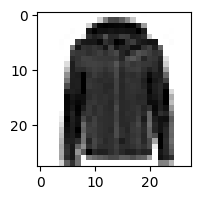

In [146]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_val, X_train = X_train_full[:5000], X_train_full[5000:]
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

plt.figure(figsize=(2,2))
plt.imshow(X_train[0], cmap='binary' )

In [147]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [150]:
from tensorflow.train import BytesList, Int64List
from tensorflow.train import Example, Features, Feature
from contextlib import ExitStack
import os

def create_single_image(image, label):
  raw_image = tf.io.serialize_tensor(image)
  
  example = Example(
    features=Features(
      feature = {
        "image": Feature(bytes_list=BytesList(value=[raw_image.numpy()])),
        "label": Feature(int64_list=Int64List(value=[label])),
      }
    )
  )
          
  return example 

def write_tfrecords(name, dataset, n_shards=25):
  paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(1, n_shards + 1)]
  
  with ExitStack() as stack:
      writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
      
      for index, (image, label) in dataset.enumerate():
          shard = index % n_shards
          example = create_single_image(image, label)
          writers[shard].write(example.SerializeToString())
  
  return paths
  
def parse_tfrecord(tfrecord):
  data = {
      'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
      'label':tf.io.FixedLenFeature([], tf.int64, default_value=-1),
  }
   
  example = tf.io.parse_single_example(tfrecord, data)
  image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
  image = tf.reshape(image, shape=[28,28])
  
  return image, example['label']

def get_dataset(pattern, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
  files = [Path(file) for file in os.listdir() if pattern in file]
  dataset = tf.data.TFRecordDataset(files, num_parallel_reads=n_read_threads)
  
  if cache:
      dataset = dataset.cache()
  if shuffle_buffer_size:
      dataset = dataset.shuffle(shuffle_buffer_size)
      
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=n_parse_threads)
  dataset = dataset.batch(batch_size)
  
  return dataset.prefetch(1)

In [151]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_dataset)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", val_dataset)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_dataset)

In [152]:
train_dataset = get_dataset(pattern = 'train.tfrecord', shuffle_buffer_size=60000)
val_dataset = get_dataset(pattern = 'test.tfrecord')
test_dataset = get_dataset(pattern = 'valid.tfrecord')

In [153]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

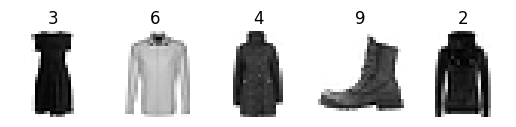

In [157]:
for (X, y) in train_dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [167]:
normalization_layer = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_dataset.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
normalization_layer.adapt(sample_images)

model = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [172]:
from datetime import datetime

logs = Path() / "my_log" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2396 - accuracy: 0.9123 - val_loss: 0.3595 - val_accuracy: 0.8800
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2249 - accuracy: 0.9159 - val_loss: 0.3773 - val_accuracy: 0.8771
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2106 - accuracy: 0.9210 - val_loss: 0.3758 - val_accuracy: 0.8764
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2008 - accuracy: 0.9253 - val_loss: 0.3640 - val_accuracy: 0.8823
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1879 - accuracy: 0.9283 - val_loss: 0.3920 - val_accuracy: 0.8794


In [173]:
%load_ext tensorboard
%tensorboard --logdir="./my_log"